In [1]:
import os
import sys

# Set the project root directory
project_root = os.path.abspath("..")  # Adjust this based on the notebook's location
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import json

# Input and output file paths
input_file = "medication_annotations.jsonl"
output_file = "filtered_medicationQA.jsonl"

def find_first_unsupported_rows(input_file, output_file):
    # Initialize an empty list to store filtered rows
    filtered_rows = []

    # Read the JSONL file
    with open(input_file, 'r') as infile:
        data = json.load(infile)["data"]  # Load the data key from the JSON file

        # Loop through each row in the data
        for row in data:
            # Check the annotation of the first claim
            if len(row["claims"]) > 0 and row["claims"][0]["annotation"] != "S":
                filtered_rows.append(row)

    # Write the filtered rows to a new JSONL file
    with open(output_file, 'w') as outfile:
        json.dump({"data": filtered_rows}, outfile, indent=2)

find_first_unsupported_rows(input_file, output_file)



In [3]:
#Add answer to filtered file
filtered_file = "filtered_hotpotqa.jsonl"
answer_file = "../index_store/conformalhotpot500/hotpot_calibrate_score_500.jsonl"

def add_answer_to_filtered_file(filtered_file, answer_file):
    # Load the filtered data
    with open(filtered_file, 'r') as infile:
        filtered_data = json.load(infile)["data"]

    # Load the answer data
    with open(answer_file, 'r') as infile:
        answer_data = [json.loads(line) for line in infile.readlines()]

    # Create a dictionary mapping question IDs to answers
    answer_dict = {row["query"]: row["answer"] for row in answer_data}

    # Add the answer to each row in the filtered data
    for row in filtered_data:
        row_ordered = {
            "prompt": row["prompt"],
            "answer": answer_dict.get(row["prompt"], "No answer"),
            "original-output": row["original-output"],
            "claims": row["claims"],
        }
        # Update the row in the list
        row.clear()
        row.update(row_ordered)

    # Write the updated data to a new JSONL file
    with open(filtered_file, 'w') as outfile:
        json.dump({"data": filtered_data}, outfile, indent=2)

add_answer_to_filtered_file(filtered_file, answer_file)

FileNotFoundError: [Errno 2] No such file or directory: 'filtered_hotpotqa.jsonl'

In [3]:
import json
input_file = 'factscore_annotations.jsonl'
support = 0
total = 0
with open(input_file, 'r') as infile:
    data = json.load(infile)["data"]
    for row in data:
        for claim in row['claims']:
            total += 1
            if claim['annotation'] == 'S' or claim['annotation'] == 'Y':
                support += 1
print(f"Total claims: {total}, Supported claims: {support}, ratio: {support/total}")


Total claims: 963, Supported claims: 952, ratio: 0.9885773624091381


In [4]:
import json
input_file = 'medication_annotations.jsonl'
support = 0
total = 0
with open(input_file, 'r') as infile:
    data = json.load(infile)["data"]
    for row in data:
        for claim in row['claims']:
            total += 1
            if claim['annotation'] == 'S' or claim['annotation'] == 'Y':
                support += 1
print(f"Total claims: {total}, Supported claims: {support}, ratio: {support/total}")


Total claims: 4271, Supported claims: 3993, ratio: 0.9349098571763054


## Create similarity at different alpha level for all 4 dataset ##

In [5]:
import numpy as np
import json
from math import ceil


CORRECT_ANNOTATIONS = ["Y", "S"]
def compute_threshold(alpha, calibration_data, a, confidence_method):
    """
    Computes the quantile/threshold from conformal prediction.
    # alpha: float in (0, 1)
    # calibration_data: calibration data
    # a: as in paper, required fraction correct, section 4.1
    # confidence_method: string
    """
    # Compute r score for each example.
    r_scores = [get_r_score(entry, confidence_method, a) for entry in calibration_data]

    # Compute threshold for conformal prection. The quantile is ceil((n+1)*(1-alpha))/n, and
    # We map this to the index by dropping the division by n and subtracting one (for zero-index).
    quantile_target_index = ceil((len(r_scores) + 1) * (1 - alpha))
    threshold = sorted(r_scores)[quantile_target_index - 1]
    return threshold

def get_r_score(entry, confidence_method, a):
    """
    Compute the r_a score for entry when confidence_method is used as the sub-claim scoring function.
    """
    threshold_set = sorted(
        [
            subclaim[confidence_method + "-score"] + subclaim["noise"]
            for subclaim in entry["claims"]
        ],
        reverse=True,
    )
    for threshold in threshold_set:
        curr_threshold = threshold
        # Apply threshold.
        accepted_subclaims = [
            subclaim
            for subclaim in entry["claims"]
            if subclaim[confidence_method + "-score"] + subclaim["noise"] >= threshold
        ]

        # Compute entailed/correct fraction.
        entailed_fraction = (
            np.mean(
                [
                    subclaim["annotation"] in CORRECT_ANNOTATIONS
                    for subclaim in accepted_subclaims
                ]
            )
            if accepted_subclaims
            else 1
        )

        if entailed_fraction < a:
            return curr_threshold
    return -1  # -1 is less than any score assigned by any of the implemented confidence methods

def load_calibration(filename="claims.jsonl"):
    """
    Reverse of dump_claims.
    """
    with open(filename, "r") as fopen:
        return json.load(fopen)["data"]

In [6]:
dataset_prefix = "factscore"
confidence_method = "similarity"

def get_threshold_for_dataset(dataset_prefixs, alphas, a, confidence_method):
    for alpha in alphas:
        result = {}
        for dataset_prefix in dataset_prefixs:
            calibration_data = load_calibration(
                f"../out/{dataset_prefix}_subclaims_with_scores.jsonl"
            )
            result[dataset_prefix] = compute_threshold(alpha, calibration_data, a, confidence_method)
        with open(f"../data/{confidence_method}_a={a:.2f}_alpha={alpha:.2f}_thresholds.json", "w") as fopen:
            json.dump(result, fopen, indent=2)

In [28]:

alphas = np.arange(0.05, 0.80, 0.05)
dataset_prefixs = ["factscore", "hotpotqa", "popqa", "medication"]
a = 1.0
get_threshold_for_dataset(dataset_prefixs, alphas, a, confidence_method)


In [ ]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
from rag.scorer.wikitexts_embedding import WikitextsDocumentScorer
from tqdm import tqdm

#global variables
wikiEmbedding = WikitextsDocumentScorer()
METHOD_SUPPORT_CONDITION = ['similarity']

def create_correctness_vs_removed_plot(
    dataset_method_prefixs, datasets, alphas, a, fig_filename, csv_filename, is_conformal = True, is_conditional=False
):
    """
    Creates leave-one-out conformal plots for all datasets in dataset_prefixs.
    """
    print(f"Producing conformal plot: {fig_filename}")
    plt.figure(dpi=800)
    target_factuality = [f"{(1-x):.2f}" for x in alphas]
    target_factuality.reverse()
    header = ["dataset"] + target_factuality
    # Write to CSV
    with open(csv_filename, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(header)
    
    #Conformal Prediction
    if is_conformal:
        for dataset_method_prefix in dataset_method_prefixs:
            confidence_method = dataset_method_prefix.split("_")[1]
            data = datasets[dataset_method_prefix]
            results = calculate_correctness_and_removal(
                data, alphas, a, confidence_method
            )

            x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
            y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]

            # Add standard error.
            yerr = [
                np.std(results_for_alpha[1]) * 1.96 / np.sqrt(len(results_for_alpha[1]))
                for results_for_alpha in results
            ]
            label = dataset_method_prefix
            csvresult = [f"{y:.3f} ± {yerr:.4f}" for y, yerr in zip(y, yerr)]
            csvresult.reverse()
            row = [label] + csvresult
            with open(csv_filename, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow(row)
            plt.errorbar(x, y, yerr=yerr, label=label, linewidth=2)

    #Conditional Conformal Perdiction
    if is_conditional:
        for dataset_method_prefix in tqdm(dataset_method_prefixs):
            confidence_method = dataset_method_prefix.split("_")[1]
            if confidence_method not in METHOD_SUPPORT_CONDITION:
                continue
            data = datasets[dataset_method_prefix]
            results = calculate_correctness_and_removal(
                data, alphas, a, confidence_method, True
            )

            x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
            y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]

            # Add standard error.
            yerr = [
                np.std(results_for_alpha[1]) * 1.96 / np.sqrt(len(results_for_alpha[1]))
                for results_for_alpha in results
            ]
            label = dataset_method_prefix + '_conditional'

            plt.errorbar(x, y, yerr=yerr, label=label, linewidth=2)

    # Plot base factuality point for the last dataset in the loop.
    x_point = x[-1]
    y_point = y[-1]
    point_size = 235
    plt.scatter(
        x_point,
        y_point,
        color="black",
        marker="*",
        s=point_size,
        label="Base factuality",
        zorder=1000,
    )

    font_size = 16
    legend_font_size = 13
    plt.title(f"Conformal Plots for Multiple Datasets (a={a})", fontsize=font_size + 4)
    plt.xlabel(
        f"Fraction achieving avg factuality >= {a}" if a != 1 else "Fraction of factual outputs",
        fontsize=font_size,
    )
    plt.ylabel("Average percent removed", fontsize=font_size)

    legend = plt.legend(
        loc="upper left", bbox_to_anchor=(0.02, 0.98), fontsize=legend_font_size
    )
    legend.get_title().set_fontsize(legend_font_size)
    plt.savefig(fig_filename, bbox_inches="tight")


def calculate_correctness_and_removal(
    data, alphas, a, confidence_method, is_conditional=False
):
    """
    Calculates correctness and fraction removed for a dataset over a range of alphas.

    Args:
        data (list): The dataset, where each entry contains claims and annotations.
        alphas (list): List of alpha values for threshold computation.
        a (float): Minimum entailed fraction threshold for correctness.
        confidence_method (str): The method used to compute confidence.

    Returns:
        list: Results containing average correctness and fraction removed for each alpha.
    """
    results = []  # first indexes into alpha, then list of (correct, frac_removed)_i
    for alpha in alphas:
        results_for_alpha = [[], []]
        for i in range(len(data)):
            # Leave-one-out calibration data
            calibration_data = data[:i] + data[i + 1 :]
            test_data = data[i]

            # Compute the threshold using the provided function
            threshold = compute_threshold(
                alpha, calibration_data, a, confidence_method
            )

            if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                conditional_threshold = compute_conditional_threshold(alpha, test_data, a, confidence_method)

                with open(f"../out/{confidence_method}_a={a:.2f}_alpha={alpha:.2f}_corectness_conditional_thresholds.jsonl", "w") as fopen:
                    json.dump({"threshold": threshold, "conditional_threshold": conditional_threshold}, fopen, indent=2)
                threshold = conditional_threshold
            # Determine accepted subclaims
            accepted_subclaims = [
                subclaim
                for subclaim in test_data["claims"]
                if subclaim[confidence_method + "-score"] + subclaim["noise"]
                >= threshold
            ]
            total_claim = len(test_data["claims"])
            fraction_removed = (
                0 if total_claim == 0 else 1 - len(accepted_subclaims) / total_claim
            )
            entailed_fraction = (
                np.mean(
                    [
                        subclaim["annotation"] in CORRECT_ANNOTATIONS
                        for subclaim in accepted_subclaims
                    ]
                )
                if accepted_subclaims
                else 1
            )
            correctness = entailed_fraction >= a
            results_for_alpha[0].append(correctness)
            results_for_alpha[1].append(fraction_removed)
            
        print(f"processing for alpha {alpha} done")
        results.append(results_for_alpha)
    return results

def compute_conditional_threshold(alpha, test_data, a, confidence_method):
    """
    Computes the conditional threshold for a test data point.
    """
    
    prompt = test_data['prompt']
    thresholds_path = f"../data/{confidence_method}_a={a:.2f}_alpha={alpha:.2f}_thresholds.json"
    
    return wikiEmbedding.calibrate_conditional_threshold(prompt, thresholds_path)

def create_calibration_plot(
    dataset_method_prefix, data, alphas, a, fig_filename, is_conditional=False
):
    """
    Creates calibration plot.
    """
    print(f"Producing calibration plot: {fig_filename}")
    fig, ax = plt.subplots(figsize=(6, 4))

    dataset_prefix = dataset_method_prefix.split("_")[0]
    confidence_method = dataset_method_prefix.split("_")[1]
    #Conformal Prediction
    split_index = len(data) // 2
    results = calculate_real_calibration_factuality(
        data, alphas, a, confidence_method
    )

    x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
    y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
    # yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

    #print(x)
    #print(y)
    # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")

    x_values = np.linspace(1-alphas[-1] - 0.05, 1-alphas[0]+0.03, 100)

    # Plot lower bound.
    y_values = x_values
    plt.plot(
        x_values, y_values, "--", color="gray", linewidth=2, label="Thrm 3.1 bounds"
    )

    # Plot upper bound
    y_values = x_values + 1 / (split_index + 1)
    plt.plot(x_values, y_values, "--", color="gray", linewidth=2)
    plt.plot(x, y, label=dataset_method_prefix, linewidth=2)
    
    if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
        results = calculate_real_calibration_factuality(
            data, alphas, a, confidence_method, True
        )

        x = [np.mean(results_for_alpha[0]) for results_for_alpha in results]
        y = [np.mean(results_for_alpha[1]) for results_for_alpha in results]
        # yerr = [np.std(results_for_alpha[1]) for results_for_alpha in results]

        #print(x)
        #print(y)
        # plt.fill_between(np.array(x), np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), color="#ADD8E6")
        plt.plot(x, y, label=dataset_method_prefix + '_conditional', linewidth=2)

    plt.xlabel(f"Target factuality (1 - {chr(945)})", fontsize=16)
    plt.legend()
    plt.ylabel("Empirical factuality", fontsize=16)
    plt.savefig(fig_filename, bbox_inches="tight", dpi=800)

def calculate_real_calibration_factuality(
    data, alphas, a, confidence_method, is_conditional=False
):
    """
    Calculates fraction of supported sub-claims in conformal set for a dataset over a range of alphas.

    Args:
        data (list): The dataset, where each entry contains claims and annotations.
        alphas (list): List of alpha values for threshold computation.
        a (float): Minimum entailed fraction threshold for correctness.
        confidence_method (str): The method used to compute confidence.

    Returns:
        list: Results containing real conformaled sub-claims factuality fraction for each alpha.
    """
    results = []  # first indexes into alpha. then list of (correct, frac_removed)_i
    conditional_threshold_cache = {}

    for alpha in tqdm(alphas):
        results_for_alpha = [[], []]
        for i in range(1000):
            # Randomly shuffle the data
            random.shuffle(data)

            # Split the data into two equal parts
            split_index = len(data) // 2
            calibration_data = data[:split_index]
            test_data = data[split_index:]

            threshold = compute_threshold(alpha, calibration_data, a, confidence_method)
            accepted_subclaim_list = []
            for test_data_point in test_data:
                if is_conditional and confidence_method in METHOD_SUPPORT_CONDITION:
                    # Use the cache to avoid re-calculating
                    prompt_key = test_data_point['prompt']
                    if prompt_key not in conditional_threshold_cache:
                        conditional_threshold = compute_conditional_threshold(
                            alpha, test_data_point, a, confidence_method
                        )
                        conditional_threshold_cache[prompt_key] = conditional_threshold
                    else:
                        conditional_threshold = conditional_threshold_cache[prompt_key]

                    with open(f"../out/{confidence_method}_a={a:.2f}_alpha={alpha:.2f}_calibration_conditional_thresholds.jsonl", "w") as fopen:
                        json.dump({"threshold": threshold, "conditional_threshold": conditional_threshold}, fopen, indent=2)
                    threshold = conditional_threshold
                
                accepted_subclaims = [
                    subclaim
                    for subclaim in test_data_point["claims"]
                    if subclaim[confidence_method + "-score"] + subclaim["noise"] >= threshold
                ]
                accepted_subclaim_list.append(accepted_subclaims)

            entailed_fraction_list = [
                (
                    np.mean(
                        [
                            subclaim["annotation"] in CORRECT_ANNOTATIONS
                            for subclaim in accepted_subclaims
                        ]
                    )
                    if accepted_subclaims
                    else 1
                )
                for accepted_subclaims in accepted_subclaim_list
            ]
            correctness_list = [
                entailed_fraction >= a for entailed_fraction in entailed_fraction_list
            ]
            fraction_correct = sum(correctness_list) / len(correctness_list)
            results_for_alpha[0].append(1 - alpha)
            results_for_alpha[1].append(fraction_correct)
        #print(f"processing for alpha {alpha} done")
        results.append(results_for_alpha)
        conditional_threshold_cache.clear() #clean cache as the cache will change for different alpha
    return results


Loaded texts from file: ../index_store/conformalhotpot500/title_text_map_hotpotqa_500_texts.json
Loaded texts from file: ../index_store/magazine/title_text_map_texts.json
Loaded texts from file: ../index_store/conformalpopqa500/title_text_map_popqa_500_texts.json
Loaded texts from file: /Users/naihefeng/Documents/2025/study/layer6/rag_conformal_pred/index_store/conformalpopqa1000/title_text_map_popqa_1000_1500_texts.json
Loaded texts from file: /Users/naihefeng/Documents/2025/study/layer6/rag_conformal_pred/index_store/hotpot_dev500/title_text_map_hotpotqa_dev_500_texts.json
Loaded texts from file: /Users/naihefeng/Documents/2025/study/layer6/rag_conformal_pred/index_store/medqa/medication_qa_ref_docs_texts.json
Loaded texts from file: ../index_store/factscore/title_text_map_factscore_texts.json


Producing conformal plot: ../out/factscore_similarity_popqa_similarity_hotpotqa_similarity_medication_similarity_factscore_gpt_a=1.00_removal_conditional_fig.png
processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done
processing for alpha 0.4 done
processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done
processing for alpha 0.4 done
processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done
processing for alpha 0.4 done
processing for a

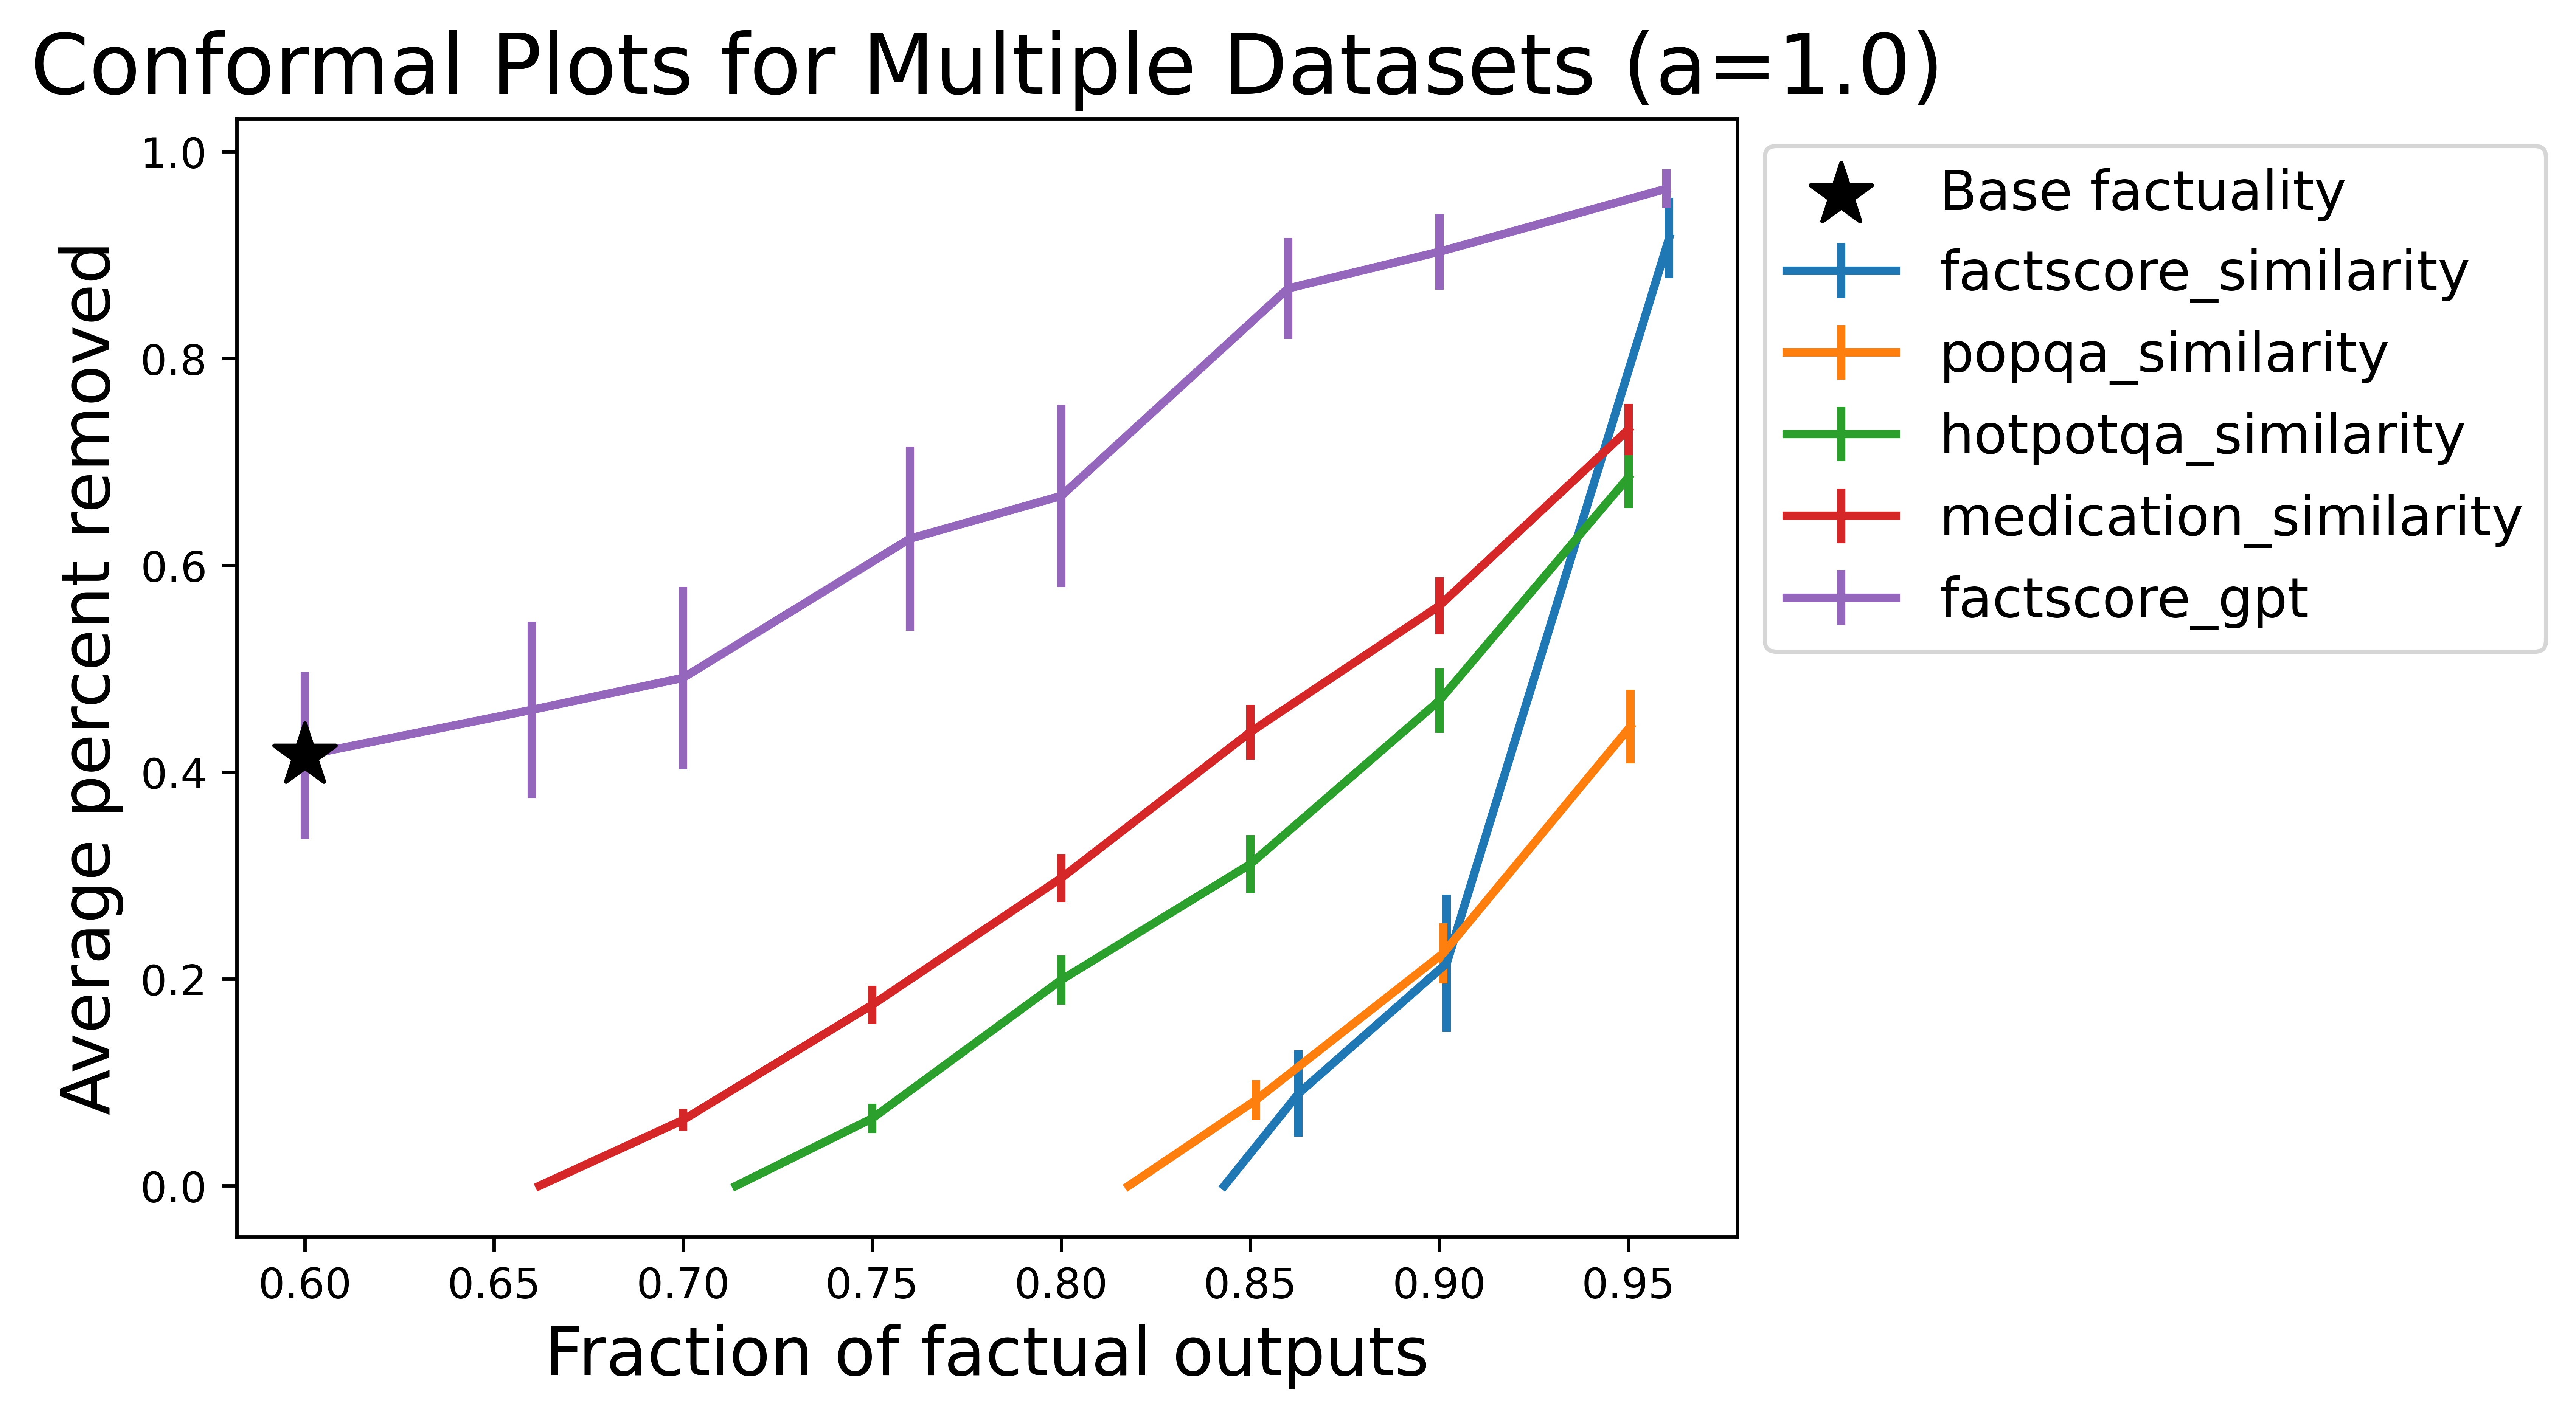

In [12]:
dataset_method_prefixs = ['factscore_similarity', 'popqa_similarity', 'hotpotqa_similarity', 'medication_similarity']#options: "factscore_gpt", "factscore_similarity", ("hotpotqa", "popqa", "medication" +"_similarity", "medication_frequency")
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
datasets = {}
for dataset_method_prefix in dataset_method_prefixs:
    dataset = dataset_method_prefix.split("_")[0]
    data = load_calibration(f"../out/{dataset}_subclaims_with_scores.jsonl")
    datasets[dataset_method_prefix] = data
#hard coded for factscore baseline
dataset_method_prefixs.append("factscore_gpt")
datasets["factscore_gpt"] = load_calibration(f"../out/factscore_gpt_subclaims_with_scores.jsonl")


dsprefixs = "_".join(dataset_method_prefixs)
fig_filename = f"../out/{dsprefixs}_a={a:.2f}_removal_conditional_fig.png"
csv_filename = f"../out/{dsprefixs}_a={a:.2f}_removal_conditional.csv"
create_correctness_vs_removed_plot(
    dataset_method_prefixs, datasets, alphas, a, fig_filename, csv_filename, is_conditional=False
)

Producing conformal plot: ../out/popqa_similarity_a=1.00_removal_conditional_fig.png
processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done
processing for alpha 0.4 done


  0%|          | 0/1 [00:00<?, ?it/s]

processing for alpha 0.05 done
processing for alpha 0.1 done
processing for alpha 0.15000000000000002 done
processing for alpha 0.2 done
processing for alpha 0.25 done
processing for alpha 0.3 done
processing for alpha 0.35000000000000003 done


100%|██████████| 1/1 [29:28<00:00, 1768.67s/it]

processing for alpha 0.4 done


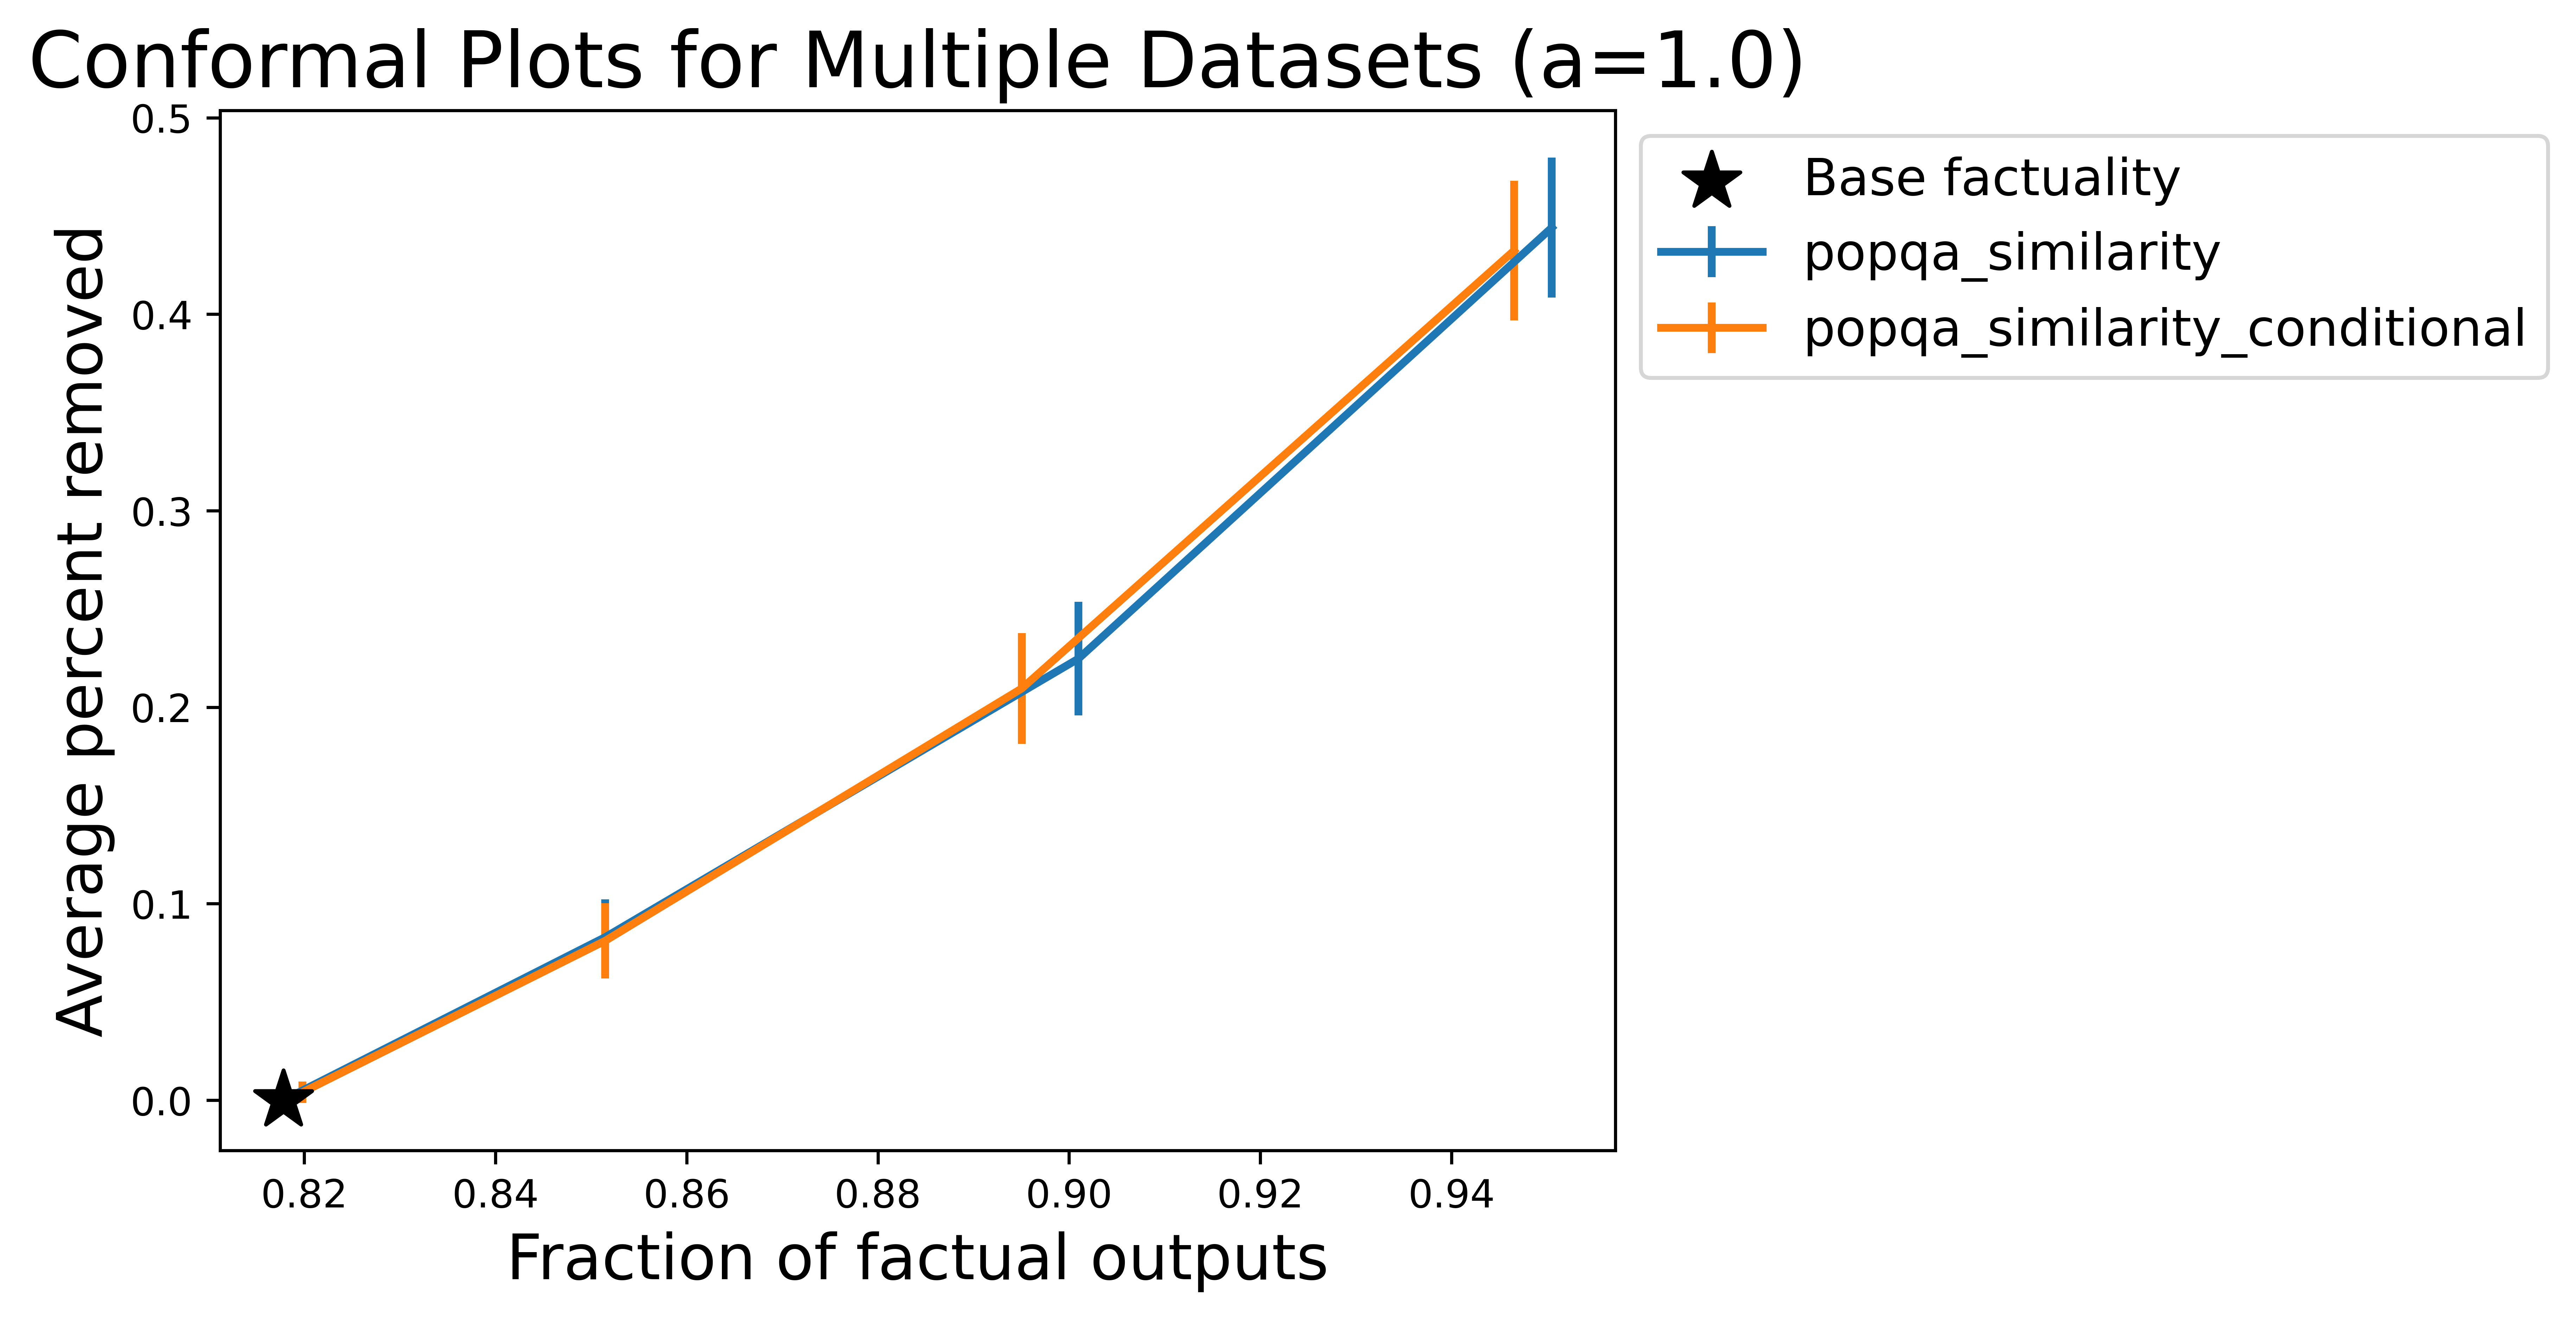

In [33]:
dataset_method_prefixs = ['popqa_similarity']#options: "factscore_gpt", "factscore_similarity", ("hotpotqa", "popqa", "medication" +"_similarity", "medication_frequency")
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
datasets = {}
for dataset_method_prefix in dataset_method_prefixs:
    dataset = dataset_method_prefix.split("_")[0]
    data = load_calibration(f"../out/{dataset}_subclaims_with_scores.jsonl")
    datasets[dataset_method_prefix] = data
dsprefixs = "_".join(dataset_method_prefixs)
fig_filename = f"../out/{dsprefixs}_a={a:.2f}_removal_conditional_fig.png"
create_correctness_vs_removed_plot(
    dataset_method_prefixs, datasets, alphas, a, fig_filename, is_conditional=True
)

Producing calibration plot: ../out/hotpotqa_similarity_a=1.00_calibration_conditional_fig.png


100%|██████████| 8/8 [30:18<00:00, 227.26s/it]


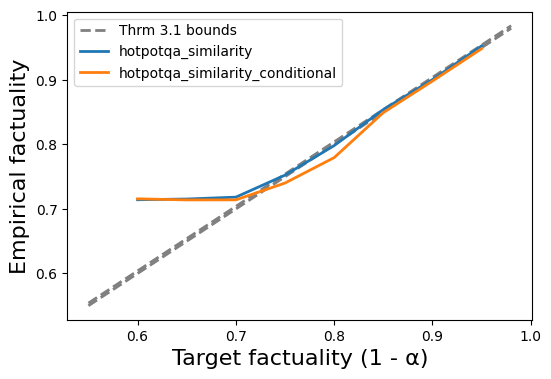

In [34]:
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
dataset_method_prefix = 'hotpotqa_similarity' #options: "factscore_gpt", "factscore_similarity",("hotpotqa", "popqa", "medication") + "_similarity"
dataset = dataset_method_prefix.split("_")[0]
confidence_method = dataset_method_prefix.split("_")[1]
data = load_calibration(f"../out/{dataset}_subclaims_with_scores.jsonl")
fig_filename = f"../out/{dataset_method_prefix}_a={a:.2f}_calibration_conditional_fig.png"
create_calibration_plot(dataset_method_prefix, data, alphas, a, fig_filename, is_conditional=True)

Producing calibration plot: ../out/popqa_similarity_a=1.00_calibration_conditional_fig.png


100%|██████████| 8/8 [32:32<00:00, 244.07s/it]


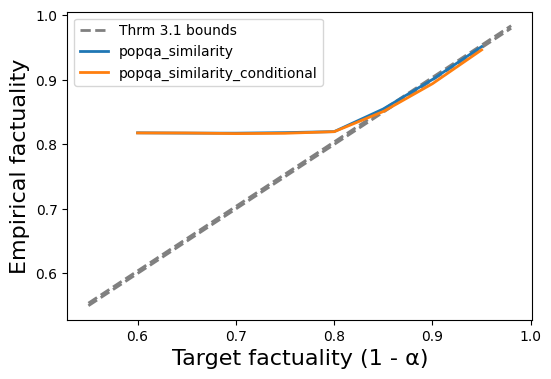

In [35]:
a=1.0
alphas = np.arange(0.05, 0.45, 0.05)
dataset_method_prefix = 'popqa_similarity' #options: "factscore_gpt", "factscore_similarity",("hotpotqa", "popqa", "medication") + "_similarity"
dataset = dataset_method_prefix.split("_")[0]
confidence_method = dataset_method_prefix.split("_")[1]
data = load_calibration(f"../out/{dataset}_subclaims_with_scores.jsonl")
fig_filename = f"../out/{dataset_method_prefix}_a={a:.2f}_calibration_conditional_fig.png"
create_calibration_plot(dataset_method_prefix, data, alphas, a, fig_filename, is_conditional=True)